## Part III: Implement RESNET-34 on Flower Dataset

1. Import Libraries

In [15]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.optim.lr_scheduler import StepLR
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, Subset
import scipy.io
import os
import tarfile
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from tqdm import tqdm

2. Define Resnet-34 architecture with residual connections

In [16]:
# ## Residual Block ##
# # The ResidualBlock for ResNet-34 consists of two 3x3 convolutional layers. 
# # A shortcut connection is added from the input of the block to the output of the second convolutional layer. 
# # If the input and output dimensions of the block are different, a 1x1 convolution is used to match the dimensions.

# class ResidualBlock(nn.Module):
#     def __init__(self, in_channels, out_channels, stride=1):
#         super(ResidualBlock, self).__init__()
#         self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
#         self.bn1 = nn.BatchNorm2d(out_channels)
#         self.relu = nn.ReLU(inplace=True)
#         self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
#         self.bn2 = nn.BatchNorm2d(out_channels)
#         self.shortcut = nn.Sequential()
#         if stride != 1 or in_channels != out_channels:
#             self.shortcut = nn.Sequential(
#                 nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
#                 nn.BatchNorm2d(out_channels)
#             )

#     def forward(self, x):
#         identity = self.shortcut(x)
#         out = self.conv1(x)
#         out = self.bn1(out)
#         out = self.relu(out)
#         out = self.conv2(out)
#         out = self.bn2(out)
#         out += identity
#         out = self.relu(out)
#         return out

In [17]:
# ## ResNet-34 Model ##
# # The complete ResNet-34 model is constructed by stacking these residual blocks. 
# # The architecture follows a specific configuration of blocks and channels.

# class ResNet34(nn.Module):
#     def __init__(self, num_classes=102):
#         super(ResNet34, self).__init__()
#         self.in_channels = 64
#         self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
#         self.bn1 = nn.BatchNorm2d(64)
#         self.relu = nn.ReLU(inplace=True)
#         self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

#         self.layer1 = self._make_layer(64, 3, stride=1)
#         self.layer2 = self._make_layer(128, 4, stride=2)
#         self.layer3 = self._make_layer(256, 6, stride=2)
#         self.layer4 = self._make_layer(512, 3, stride=2)

#         self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
#         self.fc = nn.Linear(512, num_classes)

#     def _make_layer(self, out_channels, num_blocks, stride):
#         strides = [stride] + [1] * (num_blocks - 1)
#         layers = []
#         for stride in strides:
#             layers.append(ResidualBlock(self.in_channels, out_channels, stride))
#             self.in_channels = out_channels
#         return nn.Sequential(*layers)

#     def forward(self, x):
#         out = self.conv1(x)
#         out = self.bn1(out)
#         out = self.relu(out)
#         out = self.maxpool(out)
#         out = self.layer1(out)
#         out = self.layer2(out)
#         out = self.layer3(out)
#         out = self.layer4(out)
#         out = self.avgpool(out)
#         out = torch.flatten(out, 1)
#         out = self.fc(out)
#         return out

3. Data loading and preprocessing

Dataset: Flower Dataset (https://www.robots.ox.ac.uk/~vgg/data/flowers/102/)

In [18]:
# Data transformations
transform_train = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

transform_test = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

batch_size = 64

# Download and load the dataset
train_dataset = torchvision.datasets.Flowers102(root='./data', split='train', download=True, transform=transform_train)
val_dataset = torchvision.datasets.Flowers102(root='./data', split='val', download=True, transform=transform_test)
test_dataset = torchvision.datasets.Flowers102(root='./data', split='test', download=True, transform=transform_test)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

4. Training the model

In [19]:
# device = torch.device("mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu")
# print(f"Using device: {device}")
# model = ResNet34(num_classes=102).to(device)

In [ ]:
# Using transfer learning since training samples are ver
from torchvision.models import resnet34

device = torch.device("mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu")
model = resnet34(pretrained=True) # Load pretrained ResNet-34

# Replace final layer for 102 classes
model.fc = nn.Linear(model.fc.in_features, 102)

model = model.to(device)

In [21]:
# Loss, optimizer, and scheduler
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
scheduler = StepLR(optimizer, step_size=5, gamma=0.1)

# Training loop
num_epochs = 20
best_val_accuracy = 0.0

for epoch in range(num_epochs):
    print(f"Epoch : {epoch}")
    model.train()
    running_loss = 0.0
    for i, (inputs, labels) in tqdm(enumerate(train_loader), total=len(train_loader)):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    scheduler.step()

    # Validation
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_accuracy = 100 * correct / total
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}, Val Accuracy: {val_accuracy:.2f}%')

    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        torch.save(model.state_dict(), 'best_resnet34_flowers102.pth')

Epoch : 0


100%|██████████| 16/16 [00:30<00:00,  1.93s/it]


Epoch [1/20], Loss: 4.0241, Val Accuracy: 4.31%
Epoch : 1


100%|██████████| 16/16 [00:30<00:00,  1.90s/it]


Epoch [2/20], Loss: 2.5179, Val Accuracy: 26.76%
Epoch : 2


100%|██████████| 16/16 [00:30<00:00,  1.90s/it]


Epoch [3/20], Loss: 1.7573, Val Accuracy: 54.71%
Epoch : 3


100%|██████████| 16/16 [00:30<00:00,  1.90s/it]


Epoch [4/20], Loss: 1.3167, Val Accuracy: 36.96%
Epoch : 4


100%|██████████| 16/16 [00:30<00:00,  1.90s/it]


Epoch [5/20], Loss: 1.0849, Val Accuracy: 61.18%
Epoch : 5


100%|██████████| 16/16 [00:30<00:00,  1.90s/it]


Epoch [6/20], Loss: 0.8068, Val Accuracy: 78.24%
Epoch : 6


100%|██████████| 16/16 [00:30<00:00,  1.90s/it]


Epoch [7/20], Loss: 0.5845, Val Accuracy: 82.06%
Epoch : 7


100%|██████████| 16/16 [00:30<00:00,  1.89s/it]


Epoch [8/20], Loss: 0.4868, Val Accuracy: 82.16%
Epoch : 8


100%|██████████| 16/16 [00:30<00:00,  1.90s/it]


Epoch [9/20], Loss: 0.3896, Val Accuracy: 83.43%
Epoch : 9


100%|██████████| 16/16 [00:30<00:00,  1.90s/it]


Epoch [10/20], Loss: 0.3988, Val Accuracy: 85.00%
Epoch : 10


100%|██████████| 16/16 [00:30<00:00,  1.90s/it]


Epoch [11/20], Loss: 0.3393, Val Accuracy: 85.00%
Epoch : 11


100%|██████████| 16/16 [00:30<00:00,  1.90s/it]


Epoch [12/20], Loss: 0.3264, Val Accuracy: 84.71%
Epoch : 12


100%|██████████| 16/16 [00:30<00:00,  1.90s/it]


Epoch [13/20], Loss: 0.3465, Val Accuracy: 84.90%
Epoch : 13


100%|██████████| 16/16 [00:30<00:00,  1.90s/it]


Epoch [14/20], Loss: 0.3361, Val Accuracy: 84.51%
Epoch : 14


100%|██████████| 16/16 [00:30<00:00,  1.89s/it]


Epoch [15/20], Loss: 0.3427, Val Accuracy: 85.10%
Epoch : 15


100%|██████████| 16/16 [00:30<00:00,  1.90s/it]


Epoch [16/20], Loss: 0.3186, Val Accuracy: 85.10%
Epoch : 16


100%|██████████| 16/16 [00:30<00:00,  1.90s/it]


Epoch [17/20], Loss: 0.3387, Val Accuracy: 85.29%
Epoch : 17


100%|██████████| 16/16 [00:30<00:00,  1.90s/it]


Epoch [18/20], Loss: 0.2945, Val Accuracy: 85.39%
Epoch : 18


100%|██████████| 16/16 [00:30<00:00,  1.90s/it]


Epoch [19/20], Loss: 0.2900, Val Accuracy: 85.39%
Epoch : 19


100%|██████████| 16/16 [00:30<00:00,  1.90s/it]


Epoch [20/20], Loss: 0.3229, Val Accuracy: 85.29%


5. Evaluation on Test Set

In [22]:
# Load the best model
model.load_state_dict(torch.load('best_resnet34_flowers102.pth'))
model.eval()

correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_accuracy = 100 * correct / total
print(f'Test Accuracy of the model on the 102 Flower Dataset: {test_accuracy:.2f}%')

/var/folders/xs/nhb_5fz94td50ytsrsq2jc9h0000gn/T/ipykernel_973/2056592945.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_resnet34

Test Accuracy of the model on the 102 Flower Dataset: 83.04%


6. Visualizations

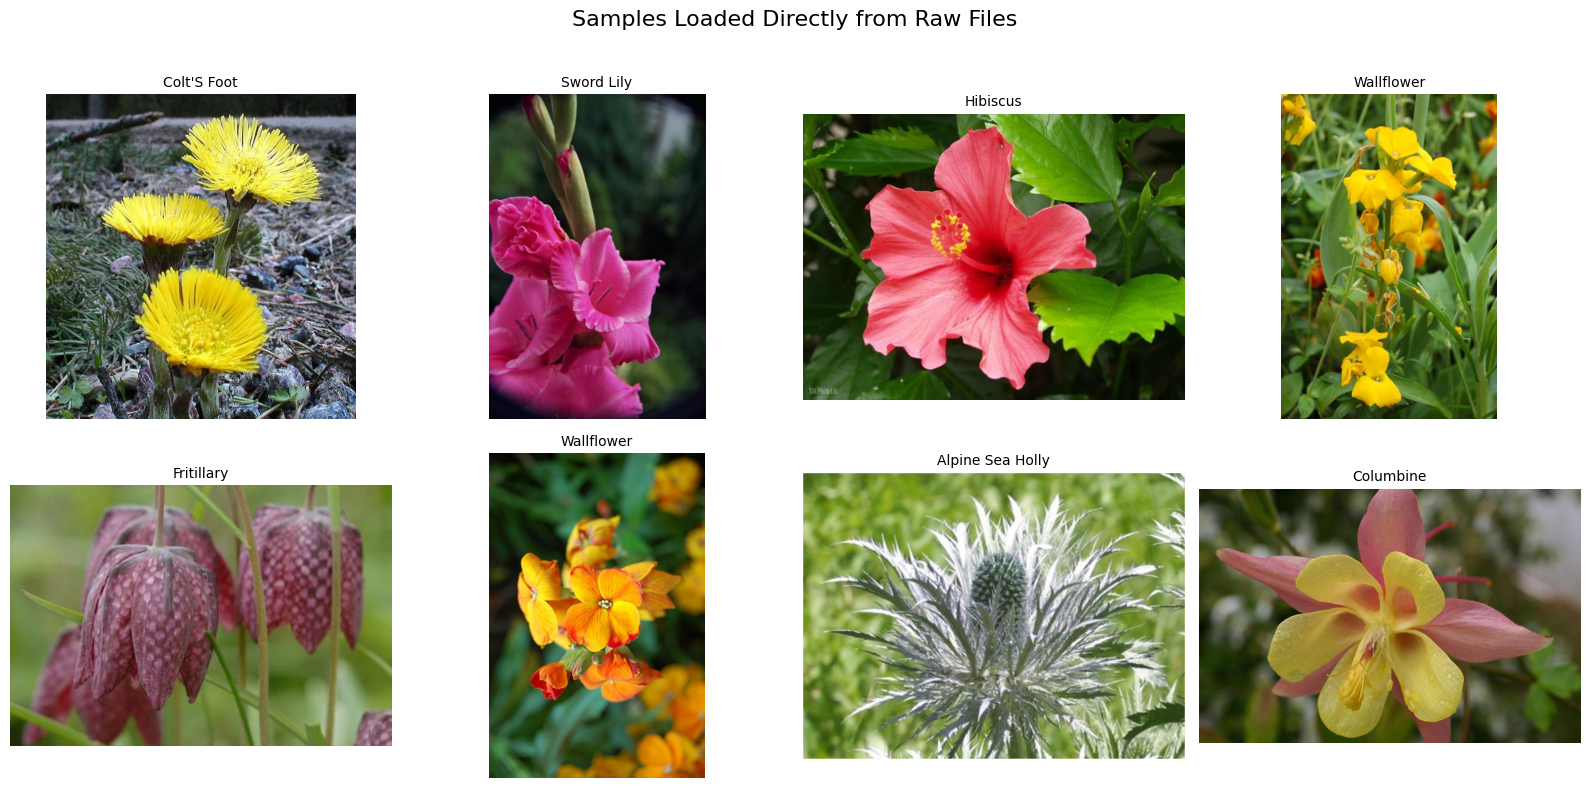

In [23]:
import scipy.io
import tarfile
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import os

# --- File Paths ---
# Make sure 102flowers.tgz and imagelabels.mat are in the same directory
tgz_path = 'data/flowers-102/102flowers.tgz'
mat_path = 'data/flowers-102/imagelabels.mat'

# --- Step 1: Define the Class Name Mapping Directly ---
# No external file needed! The dictionary is now part of the script.
cat_to_name = {
    "1": "pink primrose", "2": "hard-leaved pocket orchid", "3": "canterbury bells",
    "4": "sweet pea", "5": "english marigold", "6": "tiger lily", "7": "moon orchid",
    "8": "bird of paradise", "9": "monkshood", "10": "globe thistle", "11": "snapdragon",
    "12": "colt's foot", "13": "king protea", "14": "spear thistle", "15": "yellow iris",
    "16": "globe-flower", "17": "purple coneflower", "18": "peruvian lily", "19": "balloon flower",
    "20": "giant white arum lily", "21": "fire lily", "22": "pincushion flower", "23": "fritillary",
    "24": "red ginger", "25": "grape hyacinth", "26": "corn poppy", "27": "prince of wales feathers",
    "28": "stemless gentian", "29": "artichoke", "30": "sweet william", "31": "carnation",
    "32": "garden phlox", "33": "love in the mist", "34": "mexican aster", "35": "alpine sea holly",
    "36": "ruby-lipped cattleya", "37": "cape flower", "38": "great masterwort", "39": "siam tulip",
    "40": "lenten rose", "41": "barbeton daisy", "42": "daffodil", "43": "sword lily",
    "44": "poinsettia", "45": "bolero deep blue", "46": "wallflower", "47": "marigold",
    "48": "buttercup", "49": "oxeye daisy", "50": "common dandelion", "51": "petunia",
    "52": "wild pansy", "53": "primula", "54": "sunflower", "55": "pelargonium",
    "56": "bishop of llandaff", "57": "gaura", "58": "geranium", "59": "orange dahlia",
    "60": "pink-yellow dahlia", "61": "cautleya spicata", "62": "japanese anemone",
    "63": "black-eyed susan", "64": "silverbush", "65": "californian poppy",
    "66": "osteospermum", "67": "spring crocus", "68": "bearded iris", "69": "windflower",
    "70": "tree poppy", "71": "gazania", "72": "azalea", "73": "water lily", "74": "rose",
    "75": "thorn apple", "76": "morning glory", "77": "passion flower", "78": "lotus",
    "79": "toad lily", "80": "anthurium", "81": "frangipani", "82": "clematis",
    "83": "hibiscus", "84": "columbine", "85": "desert-rose", "86": "tree mallow",
    "87": "magnolia", "88": "cyclamen", "89": "watercress", "90": "canna lily",
    "91": "hippeastrum", "92": "bee balm", "93": "ball moss", "94": "foxglove",
    "95": "bougainvillea", "96": "camellia", "97": "mallow", "98": "mexican petunia",
    "99": "bromelia", "100": "blanket flower", "101": "trumpet creeper", "102": "blackberry lily"
}

# --- Step 2: Load Labels from .mat file ---
mat_contents = scipy.io.loadmat(mat_path)
labels = mat_contents['labels'][0]

# --- Step 3: Extract and Plot Images ---
try:
    with tarfile.open(tgz_path, "r:gz") as tar:
        # Extract all images to a 'jpg' folder if it doesn't already exist
        if not os.path.exists('jpg'):
            print("Extracting images from 102flowers.tgz...")
            tar.extractall()
        
        plt.figure(figsize=(16, 8))
        plt.suptitle("Samples Loaded Directly from Raw Files", fontsize=16)

        num_samples = 8
        random_indices = np.random.choice(len(labels), num_samples, replace=False)

        for i, image_index in enumerate(random_indices):
            # Construct the path to the image file
            image_filename = f"jpg/image_{image_index + 1:05d}.jpg"
            
            # Get the label number (1-102) and its name
            label_number = labels[image_index]
            class_name = cat_to_name[str(label_number)]

            # Open and display the image
            img = Image.open(image_filename)
            ax = plt.subplot(2, 4, i + 1)
            ax.imshow(img)
            ax.set_title(class_name.title(), fontsize=10)
            ax.axis('off')

        plt.tight_layout(rect=[0, 0, 1, 0.96])
        plt.show()

except FileNotFoundError:
    print(f"Error: Make sure '{tgz_path}' and '{mat_path}' are in the correct directory.")